In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random
from random import shuffle

Populating the interactive namespace from numpy and matplotlib


(33, 33)


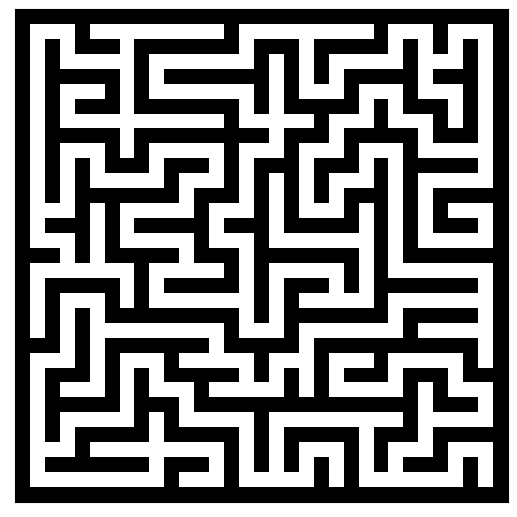

In [2]:
height = 16 # Vertical Height
width = 16  # Horizontal Width

# Generic Method for creating the Maze.
#
# Takes in the following:
#   | paramName  | DataType         | Default |
#   |-----------------------------------------|
#   | width      | int              | 16      |
#   | height     | int              | 16      |
#   |-----------------------------------------|
def make_maze(width: int = 16, height: int = 16):
    # Creates a 2D array of binary integers (0,1) of X-width and Y-height, used to keep track of visited positions as part of the traversal algorithm.
    visited = [[0] * width + [1] for _ in range(height)] + [[1] * (width + 1)]
    # Create a 2D array to represent the vertical columns in the 'Graph'
    vertical = [["10"] * width + ['1'] for _ in range(height)] + [[]]
    # Create a 2D array to represent the horizontal rows in the 'Graph'
    horizontal = [["11"] * width + ['1'] for _ in range(height + 1)]

    # Internal Method for actually generating the maze.
    # Uses 'step_x' and 'step_y' to represent the current x and y coordinates of the path.
    # The list is then shuffled to randomize the path.
    # The method then iterates over the list of coordinates and checks if the coordinate has been visited before.
    # If it has, it is skipped. If it hasn't, the vertical and horizontal arrays are updated to create the walls that are being traversed through.
    # Finally, the method is called recursively with the new coordinates and the process repeats until all the possible paths have been explored.
    #
    # Takes in the following:
    #   | paramName   | DataType         | Default |
    #   |------------------------------------------|
    #   | step_x      | int              | -       |
    #   | step_y      | int              | -       |
    #   |------------------------------------------|
    def walk(step_x: int, step_y: int):
        visited[step_y][step_x] = 1                                 # Marks the starting position as visited
        offsets = [(step_x - 1, step_y),                            # Position to the (W)
                    (step_x, step_y + 1),                           # Position to the (N)
                    (step_x + 1, step_y),                           # Position to the (E)
                    (step_x, step_y - 1)]                           # Position to the (S)
        shuffle(offsets)                                            # Shuffle the list
        for (x, y) in offsets:                                      # Loop over each position in the offset array
            if visited[y][x]: continue                              # If it's already visited then skip
            if x == step_x: horizontal[max(step_y, y)][x] = "10"    # If x is the original x-coord, then set the horizontal rows position value to '10'
            if y == step_y: vertical[y][max(step_x, x)] = "00"      # If y is the original y-coord, then set the vertical column position value to '10'
            walk(x, y)                                              # Recursively call itself

    walk(np.random.randint(width), np.random.randint(height))       # Call 'walk' from a random x and y within 16 and near-infinity

    s = "" # Maze String
    # For Loop that iterates over all columns and rows and merges them into one.
    for (a, b) in zip(horizontal, vertical):
        s += ''.join(a + ['\n'] + b + ['\n']) # Joins the horizontal and vertical arrays into a singular "maze" string

    maze = [] # Maze Structure
    for line in s.split("\n"):              # Loops over
        if line != "":                      # If the line is not empty
            row = []                        # Creates a row array structure
            for instance in line:           # For each 'instance' of a character in the line
                row.append(int(instance))   # Append the integer-converted character to the row array
            maze.append(row)                # Append the row to the maze array

    return maze # Returns the generated maze

# Specify the size of the figure as 640x640px
plt.figure(figsize=(6.4,6.4))
# Create a Numpy.array containing the randomly generated mazed.
maze = np.array(make_maze(height, width))
# Disables the default grid texture
plt.grid()
# Disables the X and Y ticks
plt.xticks(())
plt.yticks(())
# Shows a visual representation of the maze, based of its 0 and 1 values
plt.imshow(maze, cmap='Greys')
# Print the shape of the maze
print(maze.shape)

In [3]:
# Returns a Random X/Y coordinate combo
# This coordinate combo is validated to not be a wall/border (1)
def getRandomTarget():
    x = random.randint(1, width)        # Gets a random X-coordinate between 1 and width
    y = random.randint(1, height)       # Gets a random Y-coordinate between 1 and height
    while maze[x][y] == 1:              # Check that the randomly generated x,y coordinate isn't a wall
        x = random.randint(1, width)    # If it is then roll X again
        y = random.randint(1, height)   # and roll Y again
    print(x, y)                         # print the x,y coordinate
    return [x,y]                        # Return the x,y coordinate

# Returns a base policy which is based off the heuristic value of the start position and the target position:
# Values in the array are in order: N, S, W, E
def get_base_policy(start: [int,int] = [1,1], target: [int,int] = [height*2-1, width*2-1]):
    x1, y1 = start                                  # Divide up the xy of start into X and Y variables
    x2, y2 = target                                 # Divide up the xy of target into X and Y variables
    if x2 - x1 >= 0 and y2 - y1 >= 0:               # Do some cursory math to check if the target is SE of the start
        return np.array([0.22, 0.28, 0.22, 0.28])   # Default to a policy weighted towards SE
    elif x2 - x1 >= 0 and y2 - y1 <= 0:             # Do some cursory math to check if the target is NE of the start
        return np.array([0.28, 0.22, 0.22, 0.28])   # Default to a policy weighted towards NE
    elif x2 - x1 <= 0 and y2 - y1 >= 0:             # Do some cursory math to check if the target is SW of the start
        return np.array([0.22, 0.28, 0.28, 0.22])   # Default to a policy weighted towards SW
    elif x2 - x1 <= 0 and y2 - y1 <= 0:             # Do some cursory math to check if the target is NW of the start
        return np.array([0.28, 0.22, 0.28, 0.22])   # Default to a policy weighted towards NW
    else:                                           # If it's neither SE, NE, SW, NW
        return np.array([0.25, 0.25, 0.25, 0.25])   # Default to a flat policy that isn't weighted towards a particular direction

def create_base_policy_array(start: [int,int] = [1,1], target: [int,int] = [height*2-1, width*2-1]):
    w = width * 2                                                                   # The total width of the playing field is width * 2
    h = height * 2                                                                  # The total height of the playing field is height * 2
    base_policy_array = np.zeros((w,h,4))                                           # Create a 3D array of zeros with the shape w, h and 4 (NSWE)
    for x in range(w):                                                              # Loop over each possible "x" coordinate
        for y in range(h):                                                          # Loop over each possible "y" coordinate
            # Set the NSWE policy for the coordinate to be the base_policy
            # The base_policy will be based of the current x,y coordinate and the target
            # This means that the policy will always have a default weighting towards the target goal
            base_policy_array[x, y] = get_base_policy(start=[x,y], target=target)
    return base_policy_array                                                        # Return the base policy array for the maze

def train_policy(maze, policy, start: [int, int] = [1, 1], target: [int, int] = [width * 2 - 1, height * 2 - 1], iter_lengths: [] = [], learning_rate: float = 0.01, iterations: int = 256):
    allVisited = []                                                         # Set up a list of all visited positions for each run
    for i in range(iterations):                                             # Loop X times, where X is the set number of iterations to run the training

        # Create a 2D array of all possible positions to keep track if they've been visited
        visited = np.zeros((width * 2 + 1, height * 2 + 1))
        x1, y1   = start                                                    # Divide X,Y of Start into X and Y variables
        x2, y2   = target                                                   # Divide X,Y of Start into X and Y variables
        curr_x   = x1                                                       # Set the current X position to the X of start
        curr_y   = y1                                                       # Set the current Y position to the Y of start
        x_offset = [0, 1, 0, -1]                                            # Set up a default list of x_offsets
        y_offset = [1, 0, -1, 0]                                            # Set up a default list of y_offsets
        trackX   = [curr_x]                                                 # Create a list of tracked X positions and add the current X position to it
        trackY   = [curr_y]                                                 # Create a list of tracked Y positions and add the current Y position to it
        actions  = []                                                       # Create a list of actions taken by the AI
        visited[curr_x][curr_y] = 1                                         # Set the xy coordinate of the current position to visited

        while curr_x != x2 or curr_y != y2:                                 # As long as the current xy isn't the xy of the target
            action = np.random.choice([0,1,2,3],p=policy[curr_x][curr_y])   # Take a pseudo-randomized choice using the weighted policy for this position
            temp_x = curr_x + x_offset[action]                              # Set the new X position to be current_x + x_offset of the chosen action
            temp_y = curr_y + y_offset[action]                              # Set the new Y position to be current_y + y_offset of the chosen action

            if maze[temp_x][temp_y] == 0:                                   # If the new xy coordinate in the maze is an empty space and not a wall
                curr_x = temp_x                                             # Then set the current_x to the new x_coordinate
                curr_y = temp_y                                             # Then set the current_y to the new y_coordinate
                visited[curr_x][curr_y] = 1                                 # Set the currently visited position as visited in the visited array
                trackX.append(curr_x)                                       # Add the current_x to the list of tracked x positions
                trackY.append(curr_y)                                       # Add the current_y to the list of tracked y positions
                actions.append(action)                                      # Add the action taken to the action list

        for j in range(len(actions)):                                       # For each action taken
            policy[trackX[j]][trackY[j]][actions[j]] += learning_rate       # Update the policy array's values by the learning_rate

        for j in range(width * 2):                                          # For each X position
            for k in range(height * 2):                                     # For each Y position
                policy[j][k] /= policy[j][k].sum()                          # Divide the policy value by the sum of all the policy values
                                                                            # This results in the values being normalized between 0 and 1

        iter_lengths.append(len(actions))                                   # Append the length of all actions taken to the iter_length list
        allVisited.append(visited)                                          # Append the total list of visited positions to the allVisited list

    print(f"Final Policy: {str(policy)}")                                   # Print the final policy after training
    return iter_lengths, allVisited[0], allVisited[len(allVisited)-1]       # Return iter_lengths, first visited, last visited

def display(maze, policy, iteration_counts: [int], worst_visited: [int], best_visited: [int]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 12.8))

    ax1.set_title('Full Maze')
    ax1.grid()
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.imshow(maze, cmap='Reds')

    ax2.set_title('Policy Maze Map')
    ax2.grid()
    ax2.set_xlim(-0.5, 32.5)
    ax2.set_ylim(32.5, -0.5)
    ax2.set_xticks(())
    ax2.set_yticks(())
    ax2.imshow(maze, cmap='Reds')
    ax2.imshow(policy)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19.2, 12.8))
    ax1.set_title('Visisted positions for first run of RL Algorithm')
    ax1.imshow(maze, cmap='Reds')
    ax1.imshow(worst_visited, cmap='Greys')
    ax2.set_title('Visisted positions for final run of RL Algorithm')
    ax2.imshow(maze, cmap='Reds')
    ax2.imshow(best_visited, cmap='Greys')

    fig, ax = plt.subplots(figsize=(19.2, 12.8))
    ax.set_title('Iteration-Cycle Sizes')
    ax.plot(iteration_counts)

Final Policy: [[[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [3.23494521e-01 6.76505479e-01 8.87092326e-24 1.12902660e-23]
  [4.57559715e-01 2.53076781e-23 5.42440285e-01 2.53076781e-23]
  ...
  [4.57944933e-01 5.42055067e-01 2.28295211e-17 2.90557541e-17]
  [3.54353805e-01 3.90147909e-13 6.45646195e-01 3.90147909e-13]
  [4.79567318e-12 7.09309099e-01 2.90690901e-01 6.10358405e-12]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [7.26595589e-23 3.99383233e-01 7.26595589e-23 6.00616767e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [3

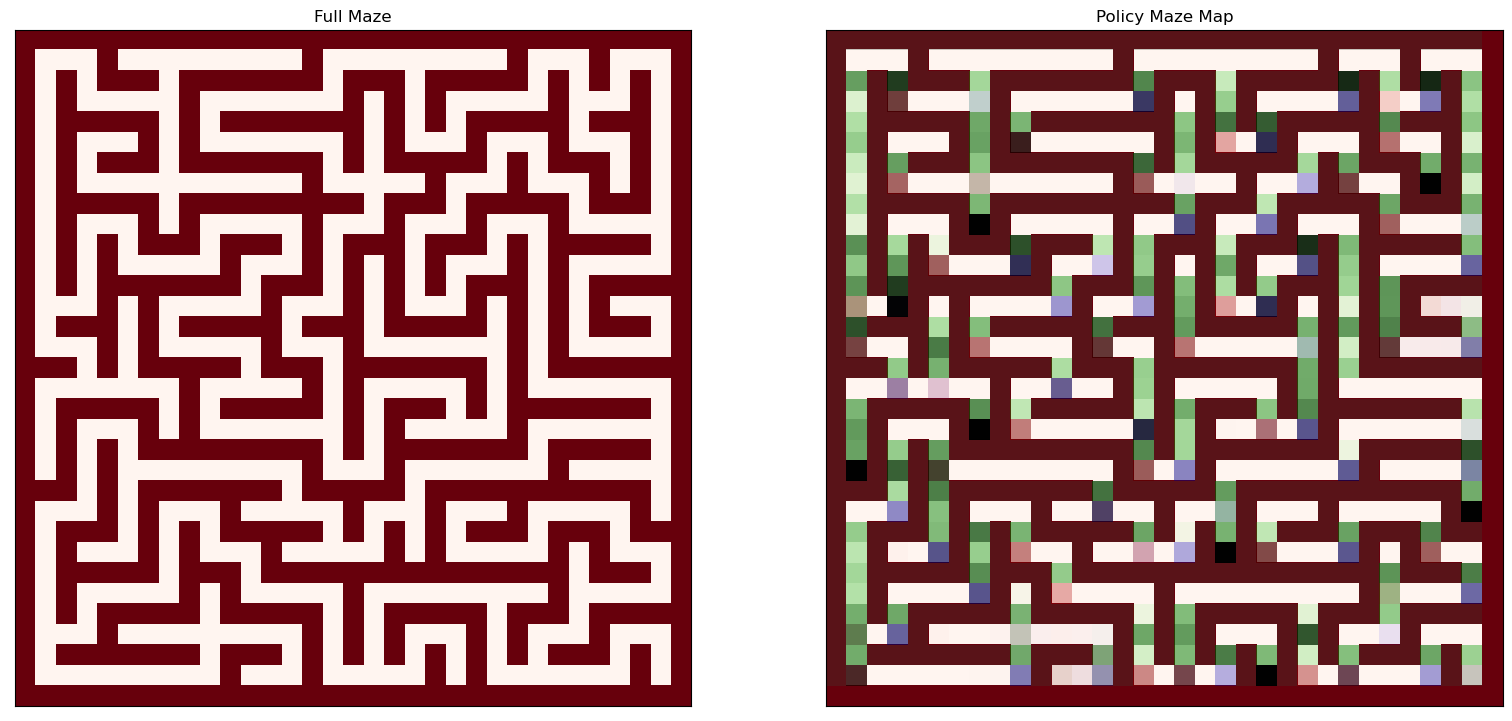

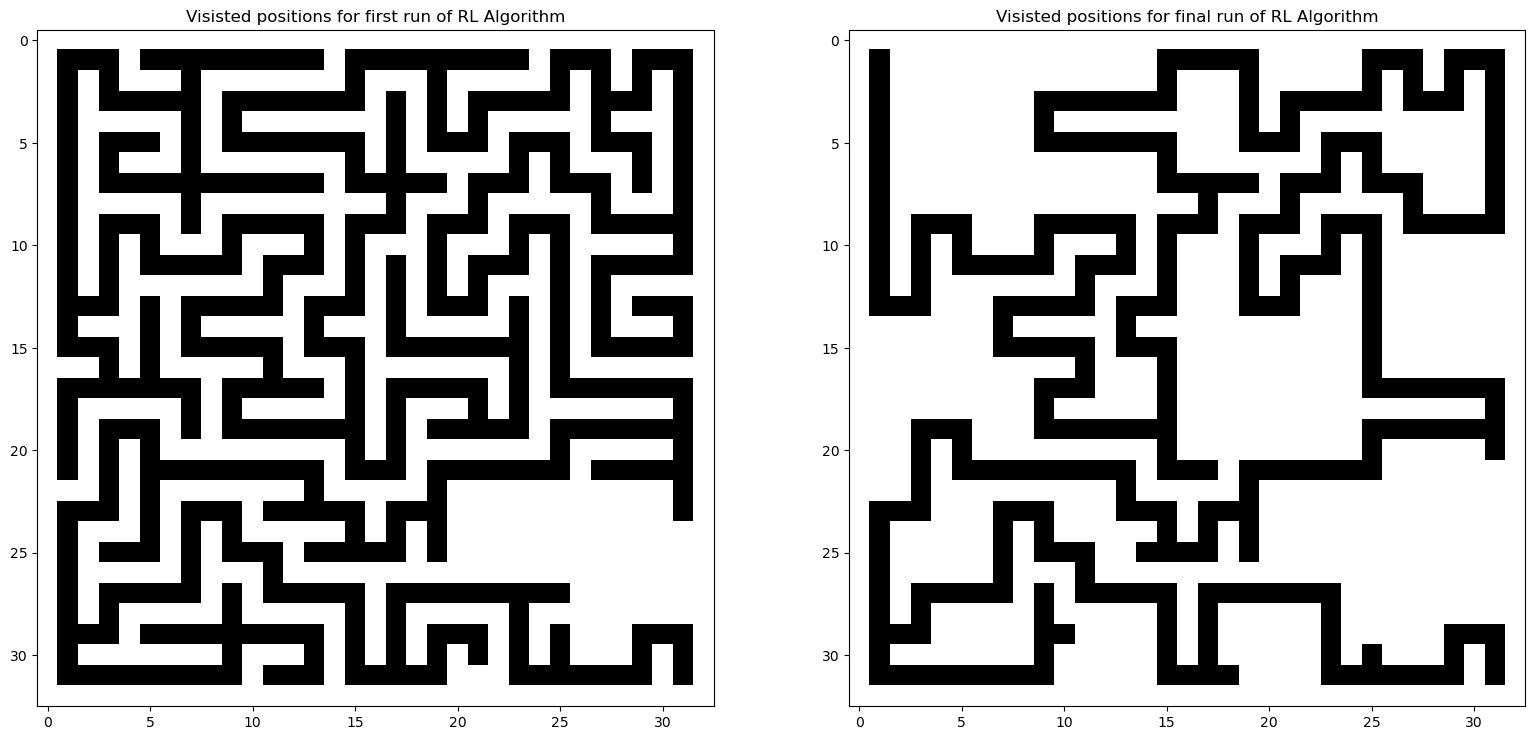

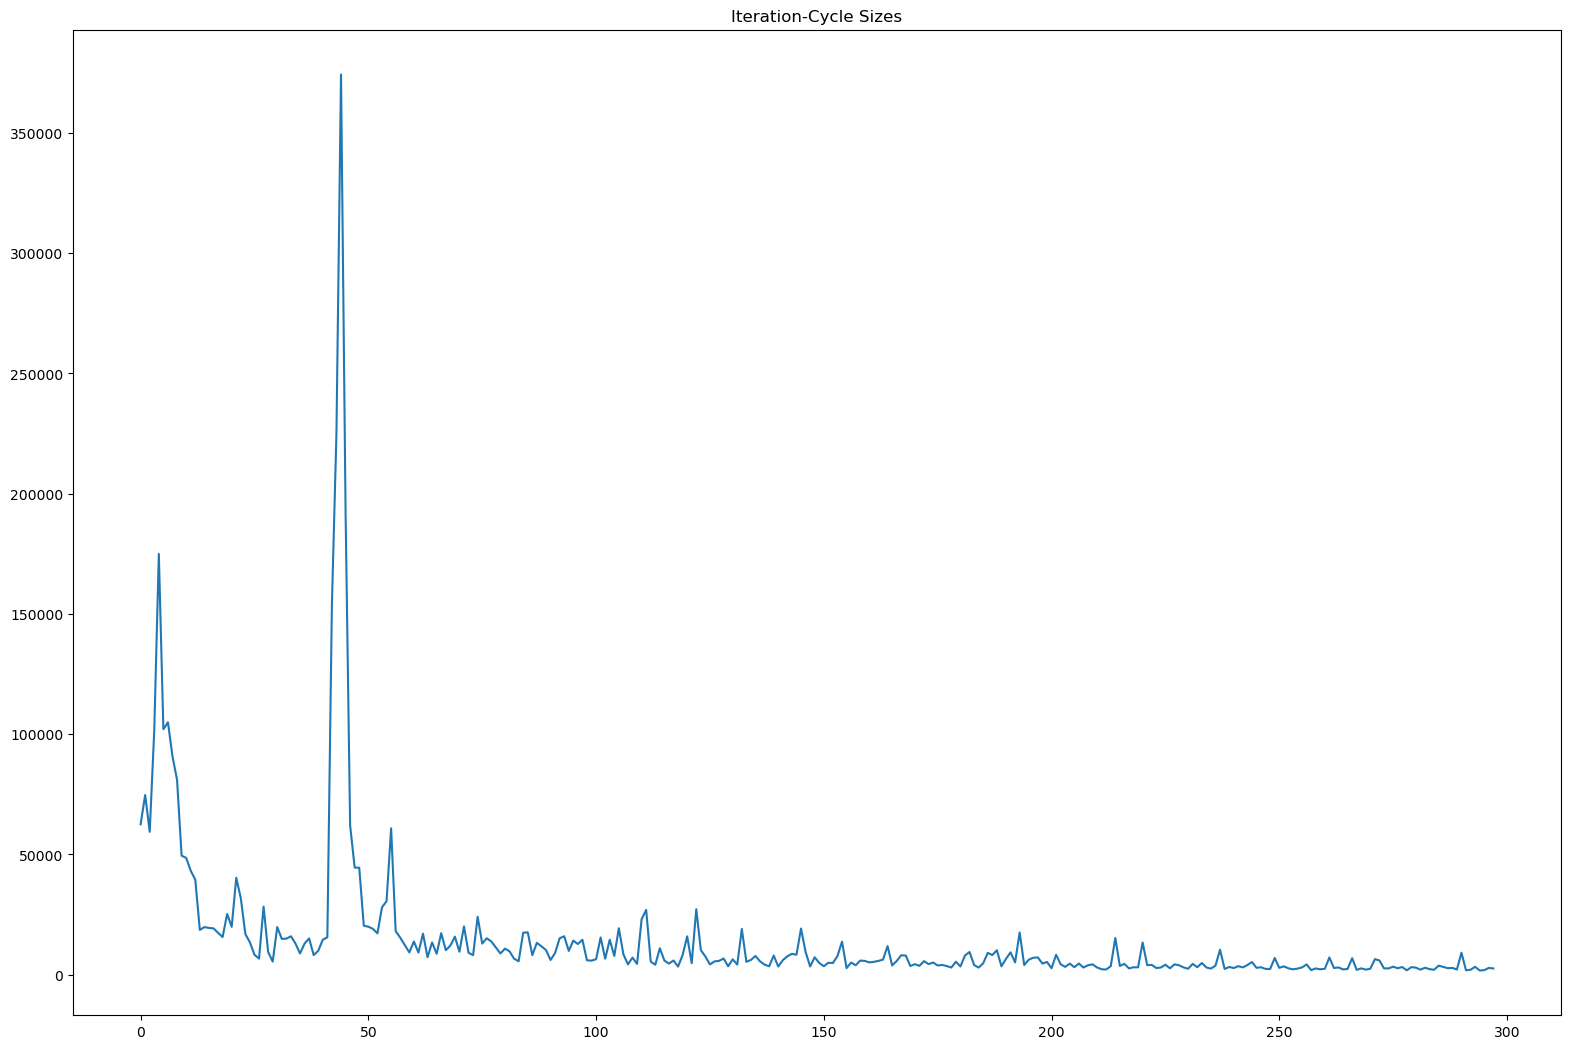

In [5]:
# Starting Position
start = [1,1]
# Target Position
target = [width * 2 - 1, height * 2 - 1]
# Learning Rate
learningRate = 0.01
# Learning Iterations
iterations = 256

policy = create_base_policy_array(start, target)
L, WV, BV = train_policy(maze, policy, start=start, target=target, learning_rate=learningRate, iterations=iterations)
display(maze, policy, L, WV, BV)

Final Policy: [[[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [4.73242047e-01 5.26757953e-01 1.80533267e-37 2.29769613e-37]
  [1.68068809e-01 2.64355977e-32 8.31931191e-01 2.64355977e-32]
  ...
  [7.61375514e-01 2.38624486e-01 2.47359753e-27 3.14821504e-27]
  [9.99999923e-01 8.80208739e-47 7.72573928e-08 8.80208739e-47]
  [5.54796300e-41 6.09125303e-01 3.90874697e-01 7.06104382e-41]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.55637742e-40 7.94197523e-01 2.55637742e-40 2.05802477e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [1

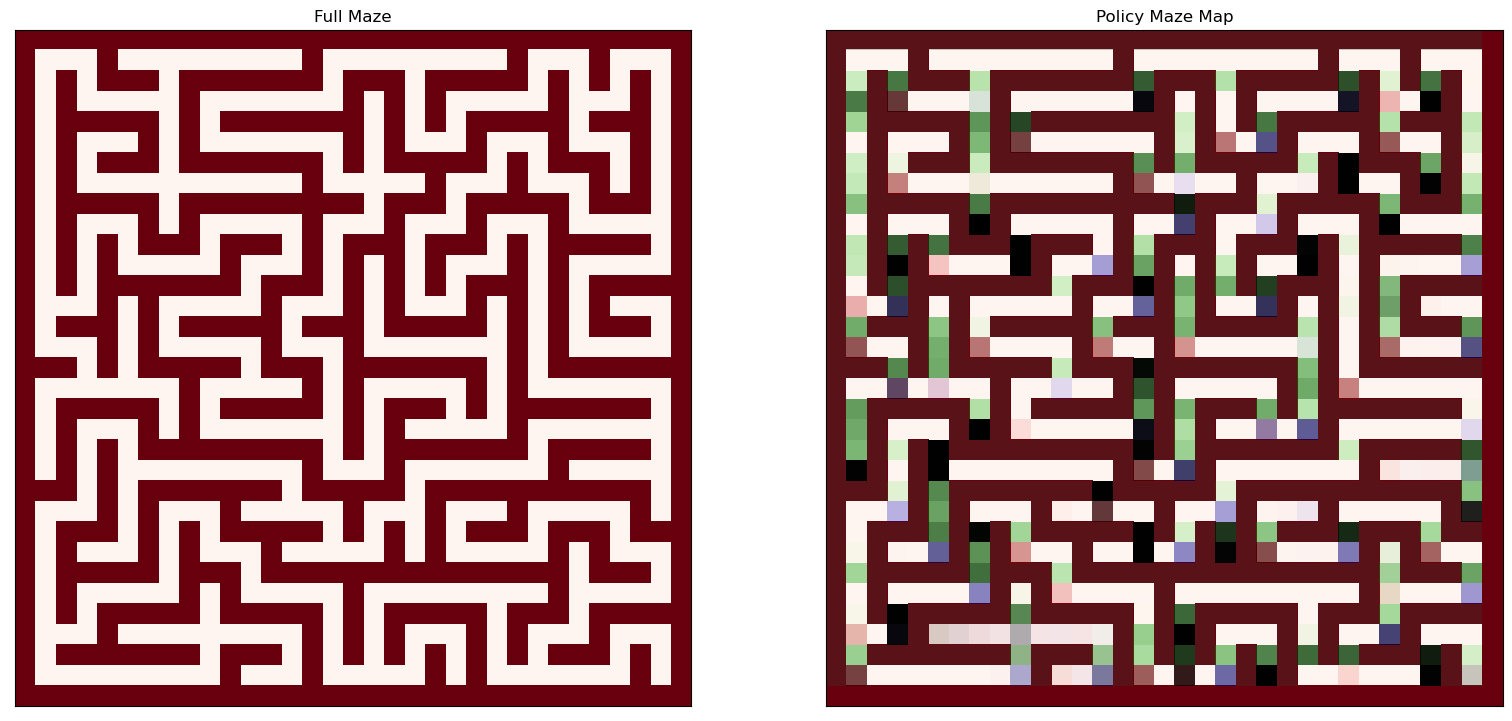

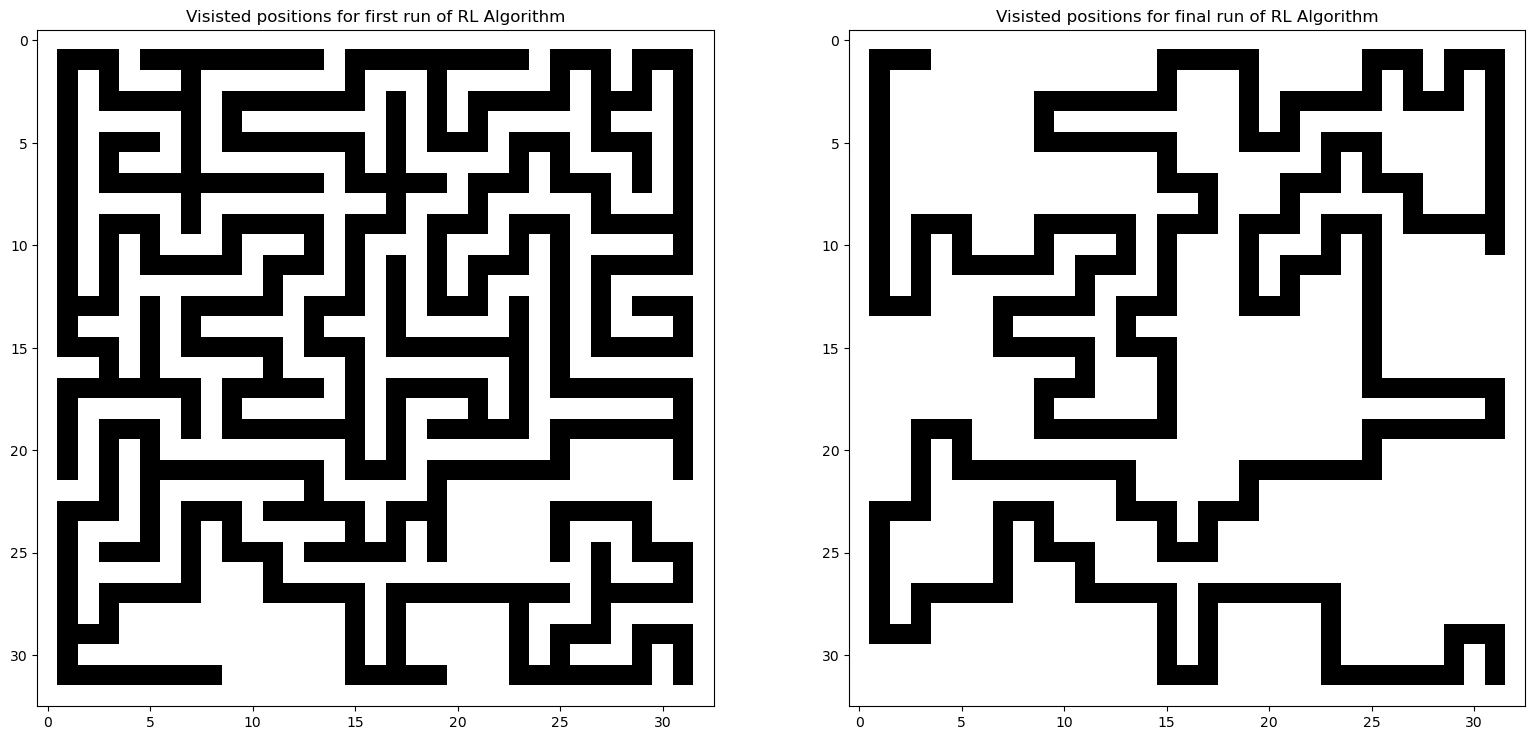

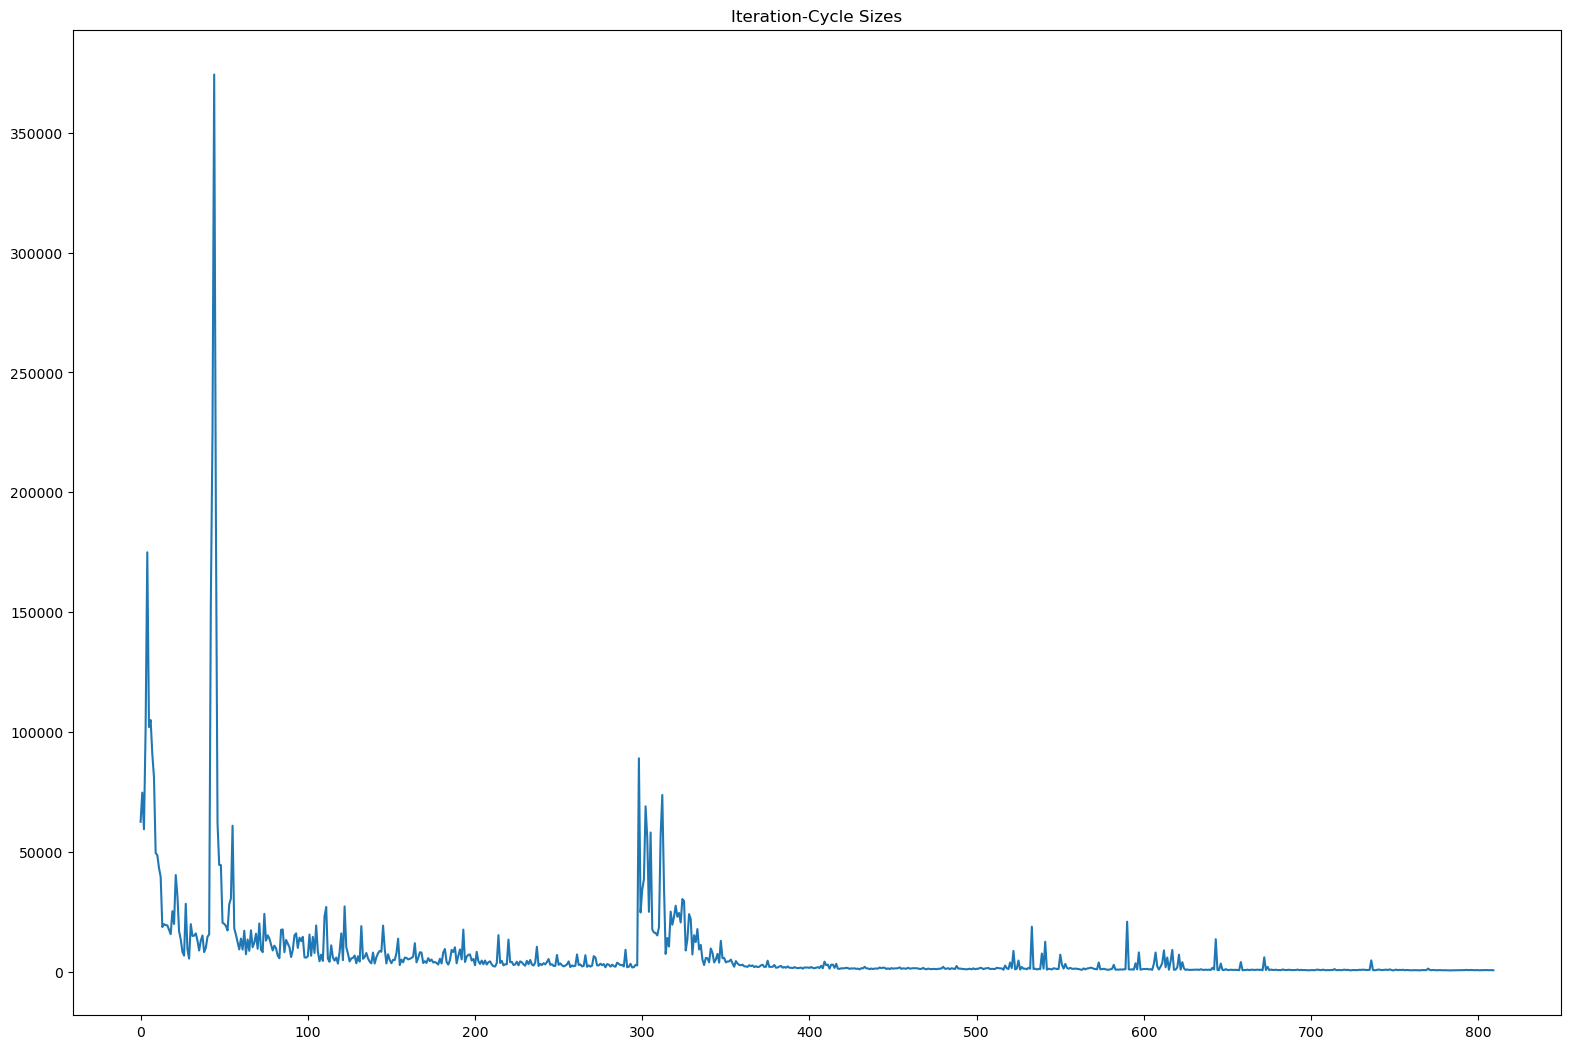

In [6]:
policy = create_base_policy_array(start, target)
L, WV, BV = train_policy(maze, policy, start=start, target=target, learning_rate=0.025, iterations=512)
display(maze, policy, L, WV, BV)

Final Policy: [[[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [2.55715233e-24 1.00000000e+00 2.12542746e-47 2.70508949e-47]
  [4.98559311e-01 8.90914735e-23 5.01440689e-01 8.90914735e-23]
  ...
  [9.99999994e-01 6.42322653e-09 3.43872481e-88 4.37655885e-88]
  [1.00000000e+00 5.37394453e-75 1.12460386e-22 5.37394453e-75]
  [8.33475624e-61 9.99999848e-01 1.52073625e-07 1.06078716e-60]]

 [[2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  [1.21968330e-49 1.00000000e+00 1.21968330e-49 3.17100404e-13]
  [2.20000000e-01 2.80000000e-01 2.20000000e-01 2.80000000e-01]
  ...
  [5

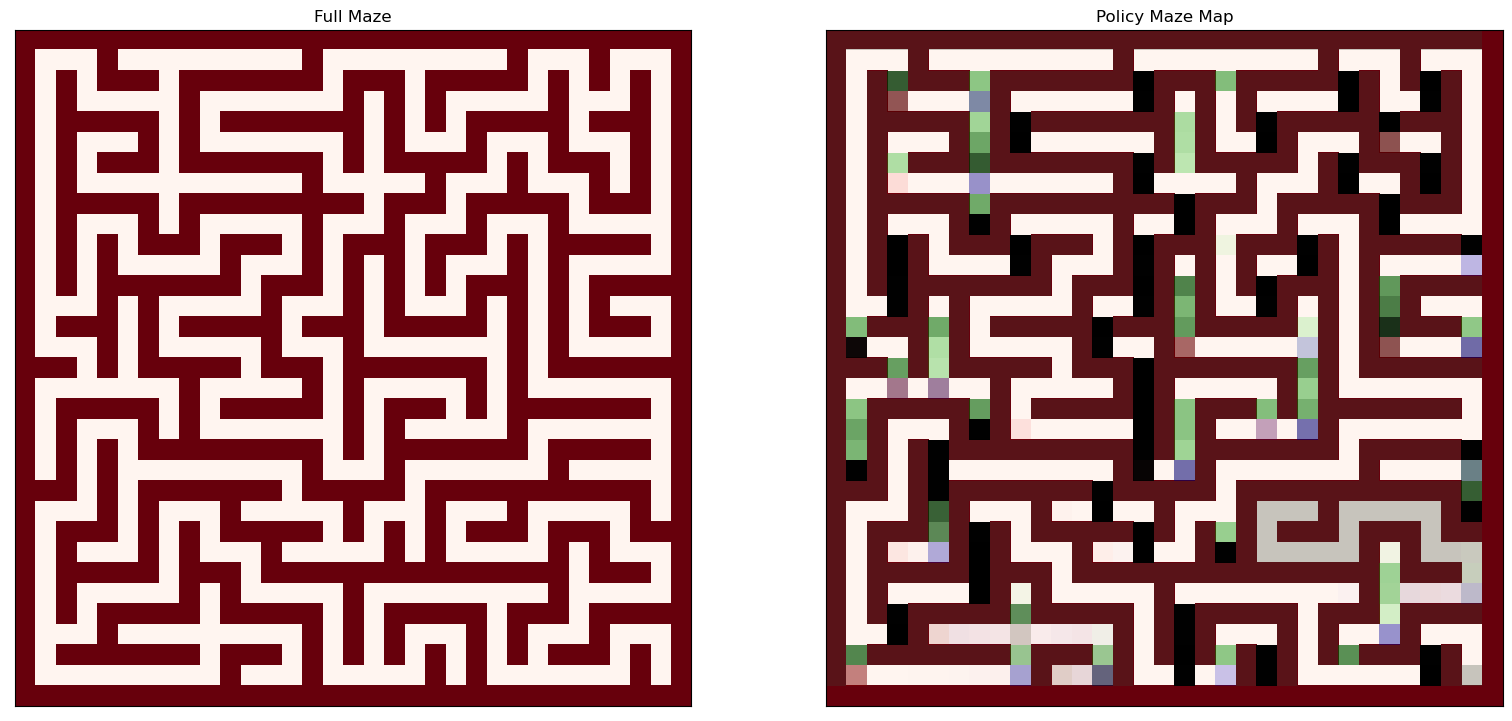

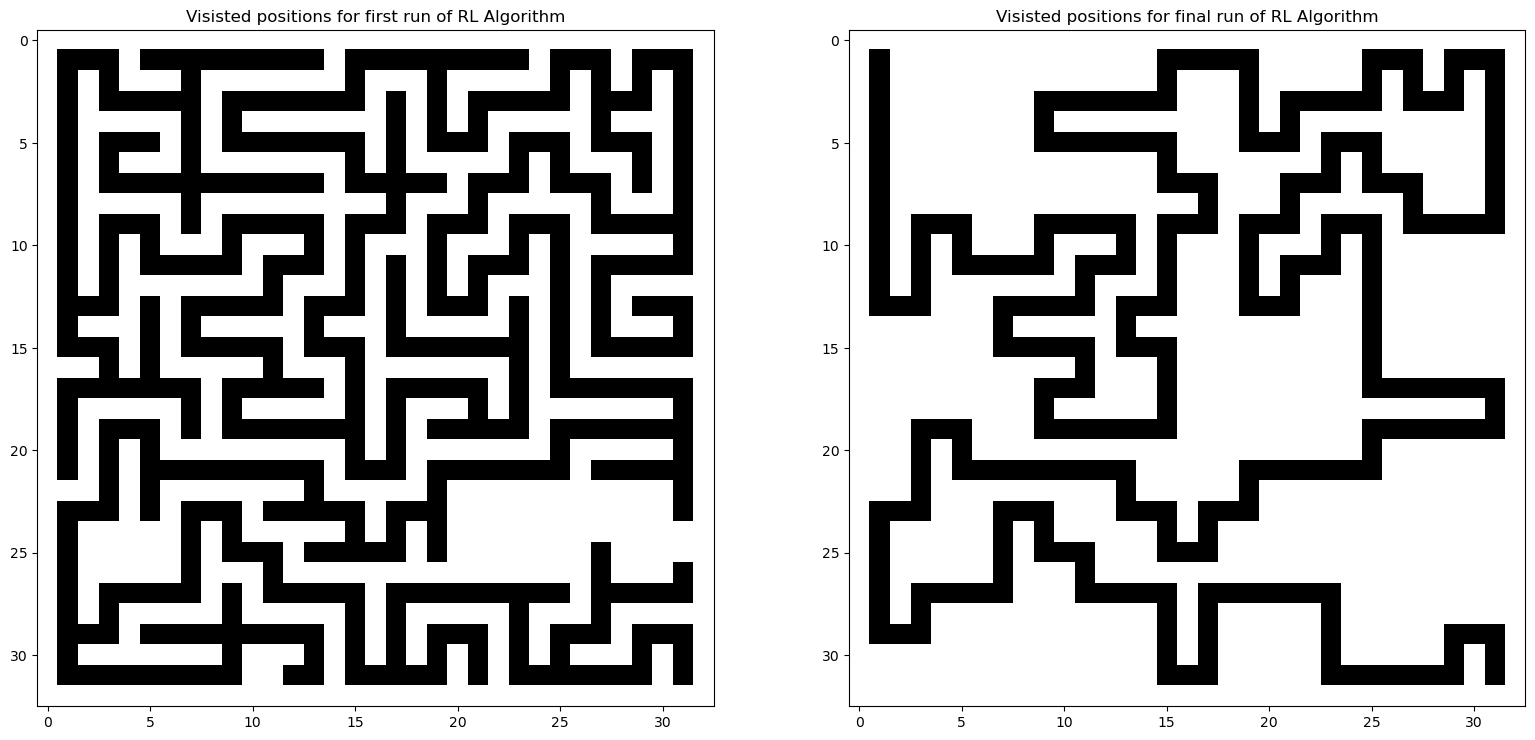

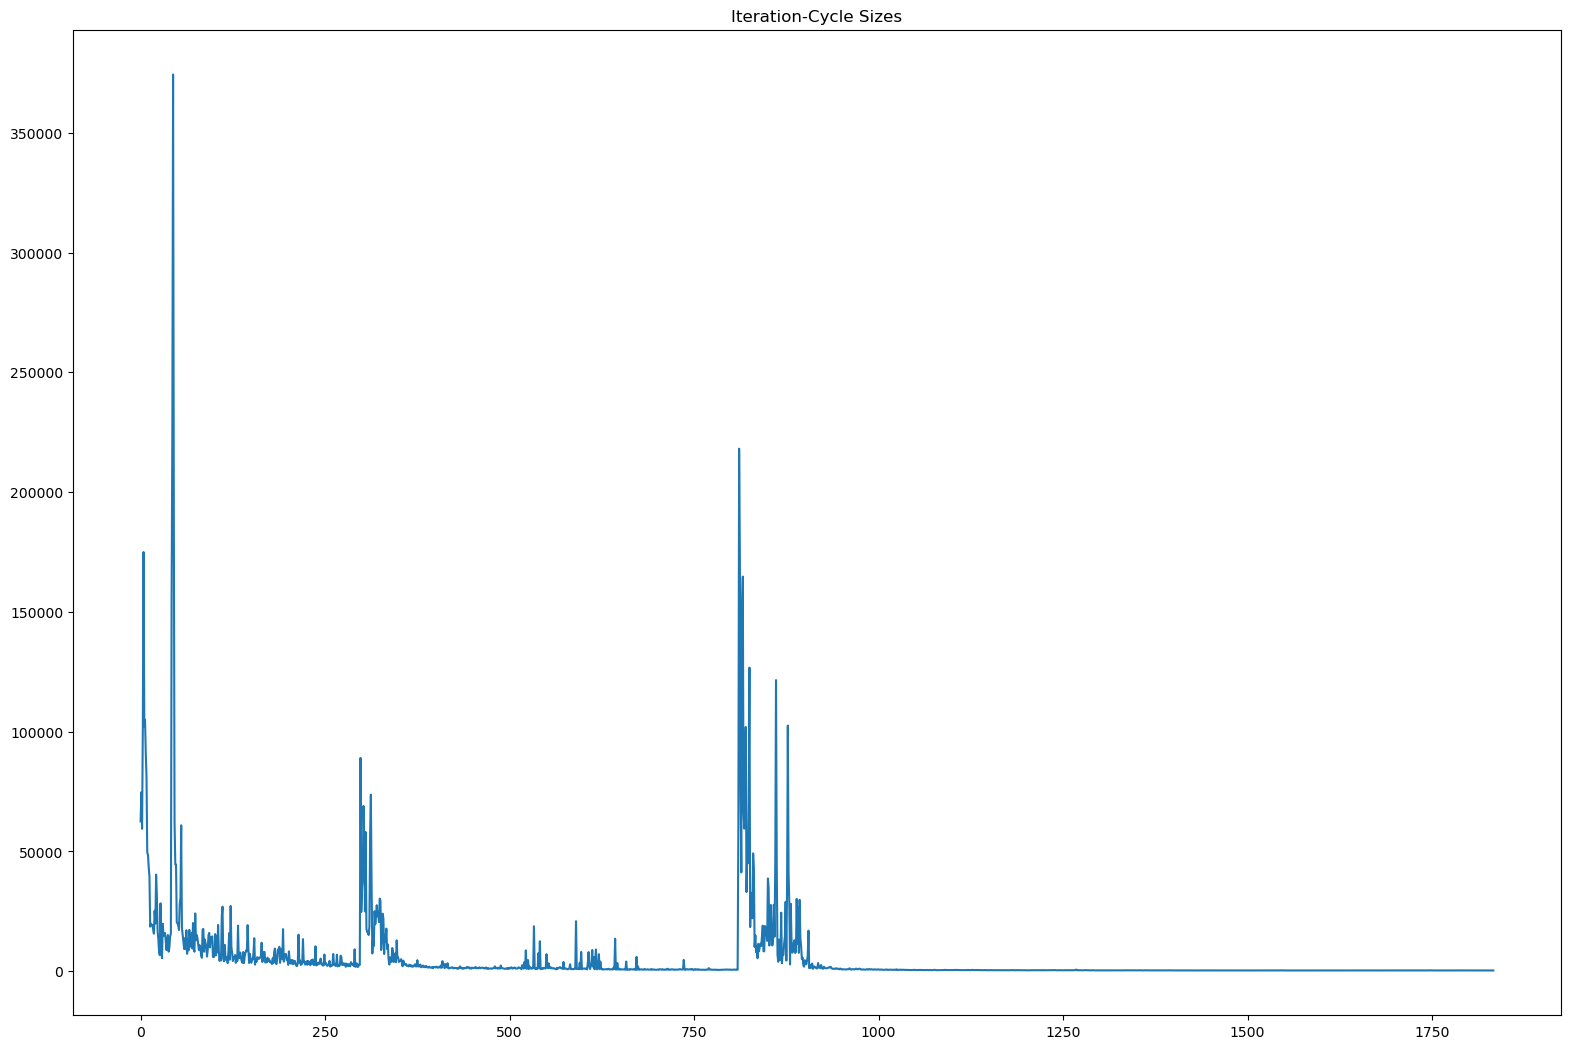

In [7]:
policy = create_base_policy_array(start, target)
L, WV, BV = train_policy(maze, policy, start=start, target=target, learning_rate=0.05, iterations=1024)
display(maze, policy, L, WV, BV)

4 9
Final Policy: [[[2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  ...
  [2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]]

 [[2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [3.96969697e-001 5.27272727e-001 3.33333333e-002 4.24242424e-002]
  [4.87096774e-001 4.51612903e-002 4.22580645e-001 4.51612903e-002]
  ...
  [1.00000000e+000 2.62372987e-080 1.66859082e-098 2.12366104e-098]
  [1.00000000e+000 4.62468227e-099 3.09486997e-088 4.62468227e-099]
  [6.45460628e-098 1.00000000e+000 6.70200558e-079 8.21495345e-098]]

 [[2.20000000e-001 2.80000000e-001 2.20000000e-001 2.80000000e-001]
  [3.54838710e-002 3.67741935e-001 3.54838710e-002 5.61290323e-001]
  [2.20000000e

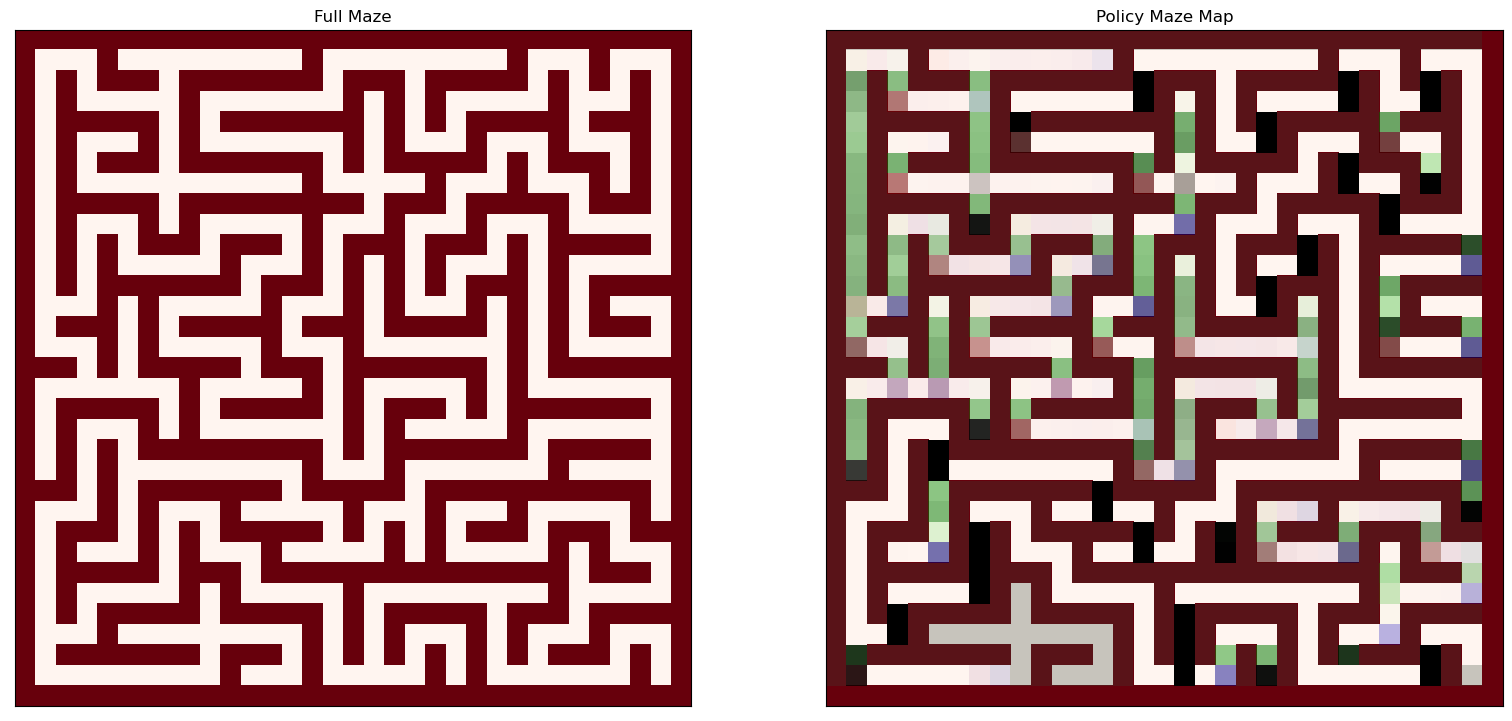

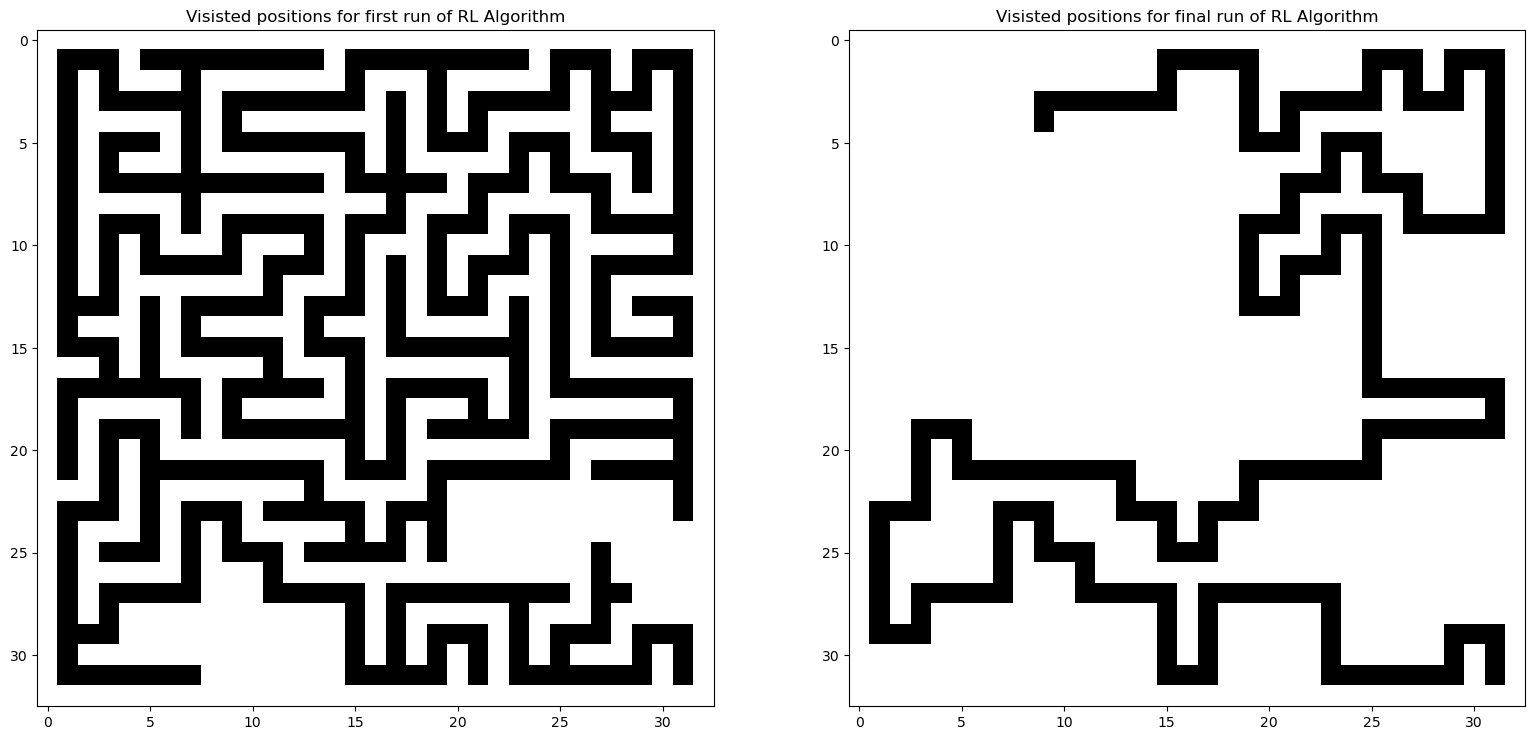

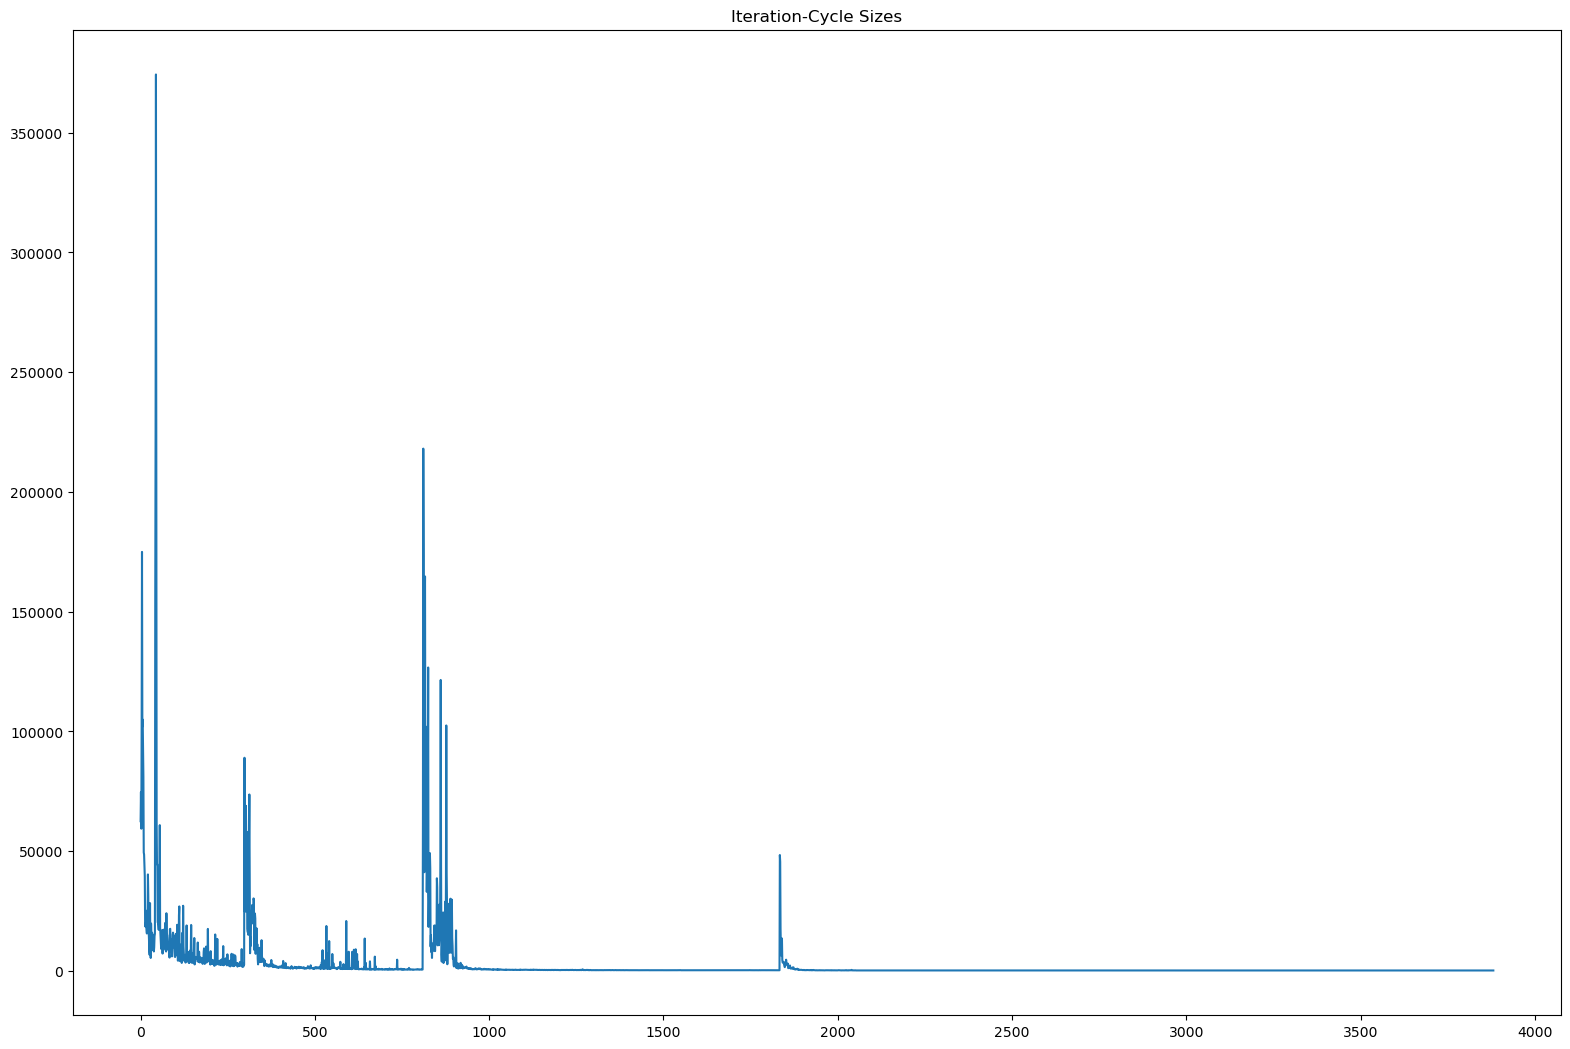

In [8]:
# Starting Position
start = getRandomTarget()
policy = create_base_policy_array(start, target)

L, WV, BV = train_policy(maze, policy, start=start, target=target, learning_rate=0.1, iterations=2048)
display(maze, policy, L, WV, BV)